# Using Y-factor method to calculate active component noise

In [27]:
import os
import glob
from os.path import join as pjoin

In [28]:
from highz_exp.fit_temperature import Y_Factor_Thermometer
from highz_exp.s_params import S_Params
from highz_exp.spec_class import Spectrum
from highz_exp import plotter

pjoin = os.path.join
pbase = os.path.basename

data_path = os.path.expanduser("~/Desktop/High-Z/SA_Measurements")
output_path = pjoin(data_path, 'Processed')
plot_path = pjoin(data_path, 'Plots')

if os.path.exists(output_path) is False:
    os.makedirs(output_path)
if os.path.exists(plot_path) is False:
    os.makedirs(plot_path)

In [29]:
# define macros
# nchannels = 4
import numpy as np

nfft = 32768
fs = 3276.8/4
fbins = np.arange(0, nfft//2)
df = fs/nfft
faxis = fbins*df
faxis_hz = faxis*1e6
freq_range = (0, 500) # MHz
y_41_5 = []
y_43 = []
for i in range(len(faxis)):
    y_41_5.append(-41.5)
    y_43.append(-43)

### Calibrated Y-Factor Method for Noise Temperature Measurement of Active Components

In [30]:
# import csv helper functions for data saved from SAX3000
from highz_exp import load_csv

In [31]:
# load data for WEA102
system_file = pjoin(data_path, 'WEA102.csv')
load_csv.split_csv_by_trace_name(system_file, 
                                 header_file=pjoin(output_path, 'WEA102_header.csv'),
                                 data_file= pjoin(output_path, 'WEA102_data.csv'))

Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/WEA102_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/WEA102_data.csv (755 rows)


In [32]:
traces = load_csv.parse_trace_data(pjoin(output_path, 'WEA102_data.csv'))

# plot the recorded spectra from hot-cold measurements
spectrum_D = Spectrum(traces['Trace D']['frequency'], traces['Trace D']['spectrum'], name='77K load - WEA102')
spectrum_B = Spectrum(traces['Trace B']['frequency'], traces['Trace B']['spectrum'], name='300K load - WEA102')

Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 751 data points
Successfully parsed 4 traces with data


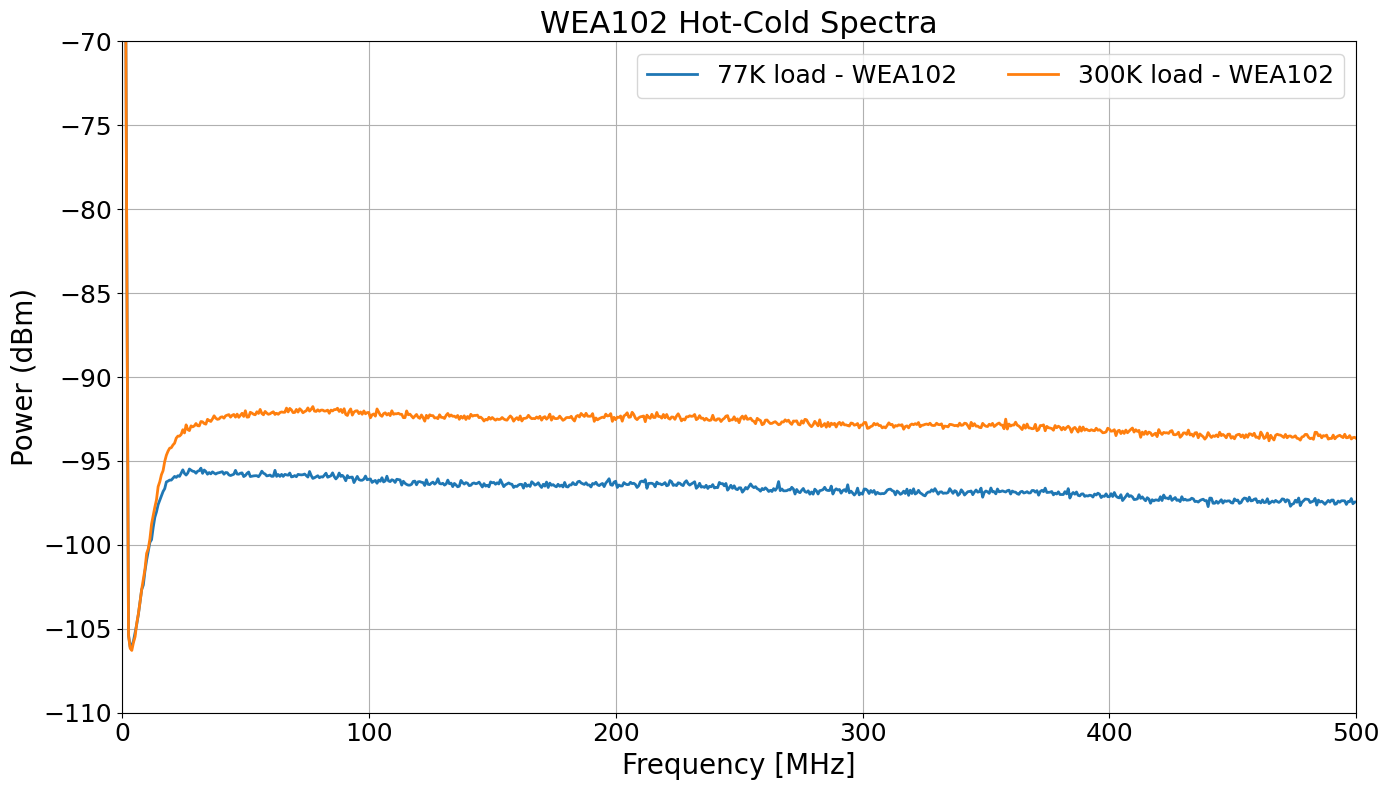

In [33]:
plotter.plot_spectrum([spectrum_D, spectrum_B], freq_range=freq_range, title='WEA102 Hot-Cold Spectra',
                        ylabel='Power (dBm)', ymax=-70, ymin=-110)

In [34]:
# smoothed spectra
spectrum_B.smooth(window_len=50, inplace=True)
spectrum_D.smooth(window_len=50, inplace=True)

<Spectrum name='77K load - WEA102' points=751 metadata_keys=[]>

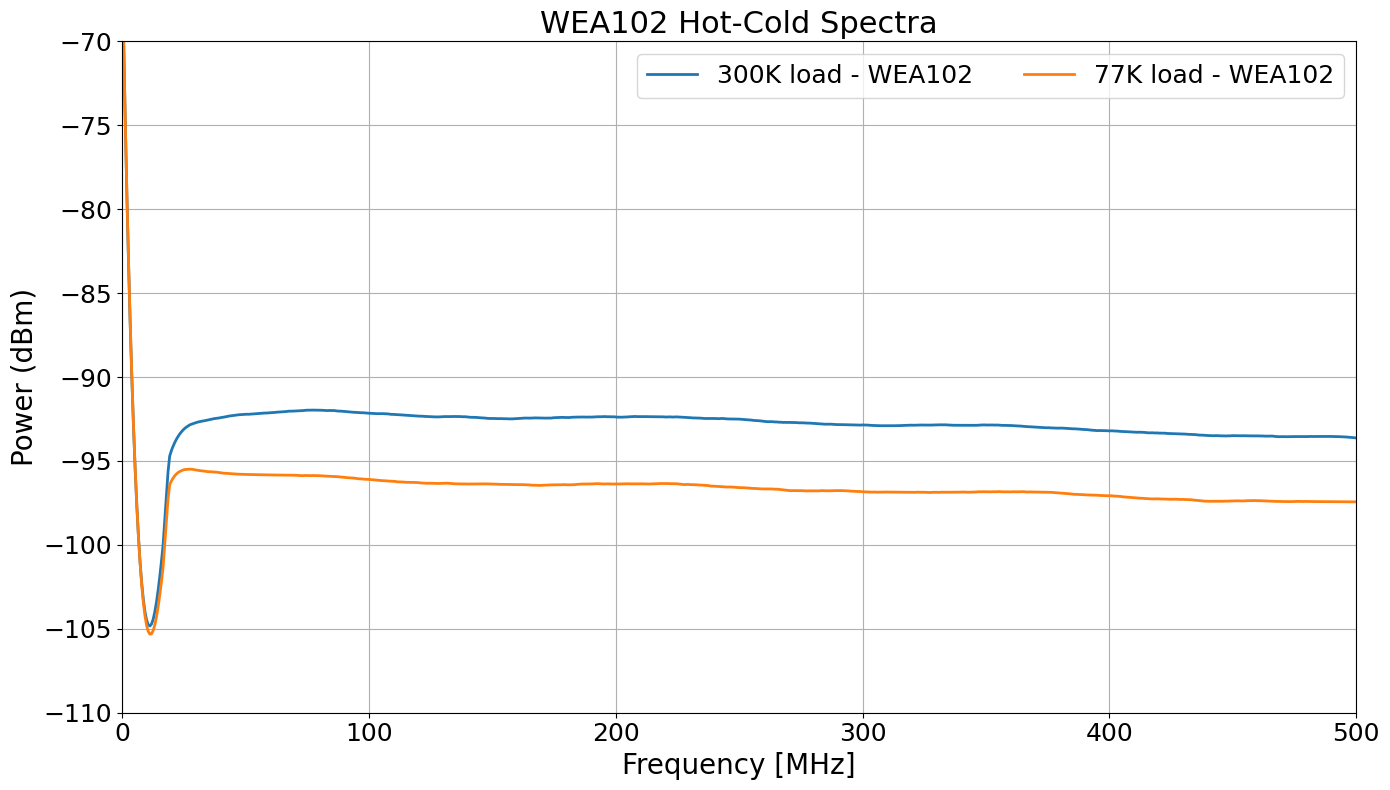

In [35]:
plotter.plot_spectrum([spectrum_B, spectrum_D], freq_range=freq_range, title='WEA102 Hot-Cold Spectra', 
                      ylabel='Power (dBm)', ymax=-70, ymin=-110, save_dir=plot_path, suffix='smoothed')

In [36]:
# Calculate the Y-Factor thermometer
cal_hot = spectrum_B.unit_convert('dBm', 'milliwatt', 1e6).spec
cal_cold = spectrum_D.unit_convert('dBm', 'milliwatt', 1e6).spec
WEA102_thermo = Y_Factor_Thermometer(cal_hot, cal_cold, 'WEA102+SA', 300, 77, RBW=1e6)

frequency = spectrum_B.freq/1e6  # MHz

/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:94: RuntimeWarning: invalid value encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / ((T_hot - T_cold) * k_B * RBW))


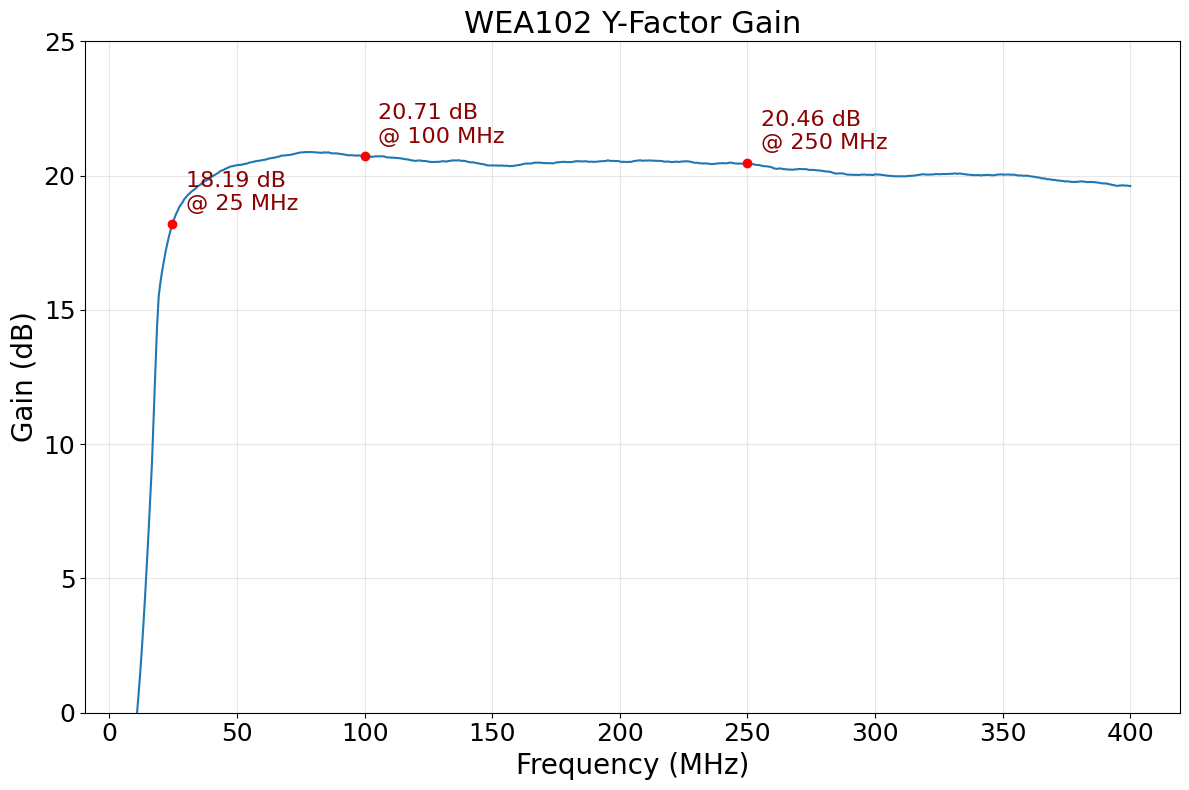

In [37]:
WEA102_thermo.plot_gain(f_mhz=frequency, ymax=25, ymin=0, title='WEA102 Y-Factor Gain',
                        save_path=pjoin(plot_path, 'WEA102_YFactor_Gain.png'), 
                        marker_freqs=[25, 100, 250])

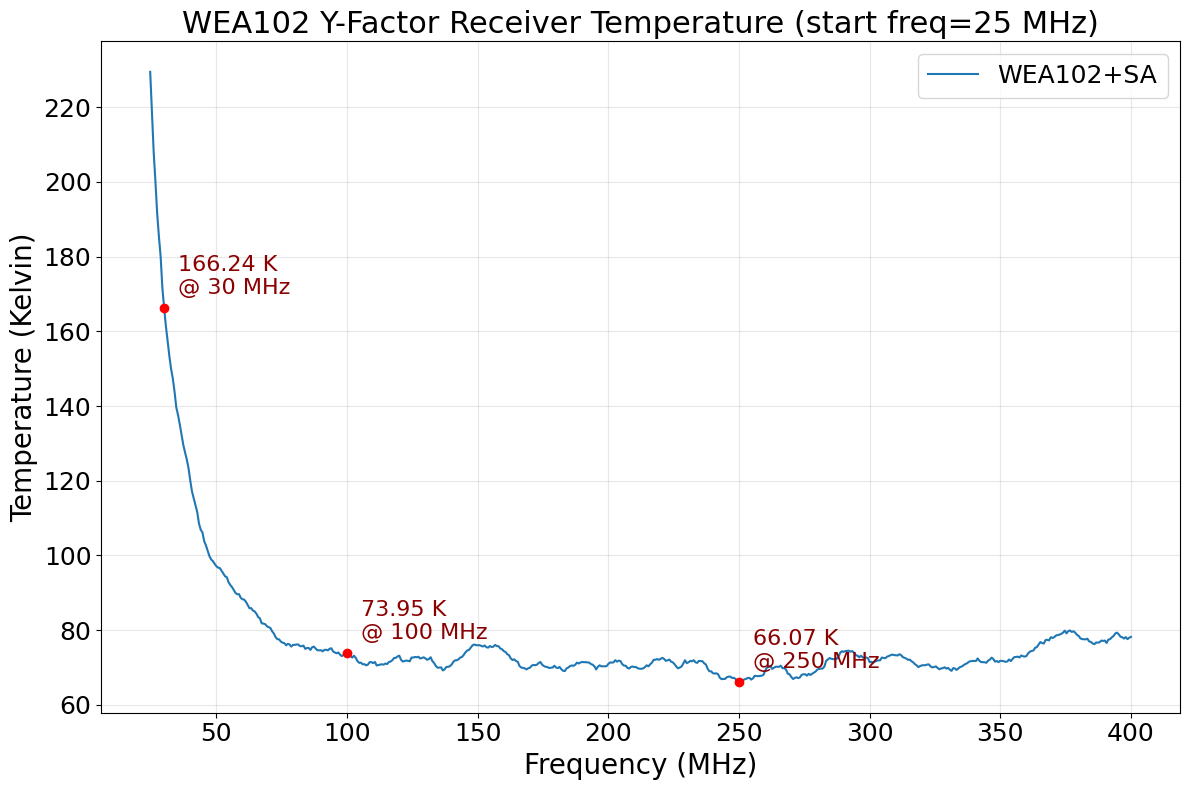

In [38]:
WEA102_thermo.plot_temps(faxis=frequency, temp_values=[WEA102_thermo.T_sys], labels=['WEA102+SA'],
                         title='WEA102 Y-Factor Receiver Temperature (start freq=25 MHz)',
                         start_freq=25,
                         save_path=pjoin(plot_path, 'WEA102_YFactor_Temps.png'),
                         marker_freqs=[30, 100, 250])

In [39]:
# load data for WEA101 + LNA01
system_file = pjoin(data_path, 'LNA01.csv')
load_csv.split_csv_by_trace_name(system_file, 
                                 header_file=pjoin(output_path, 'WEA101_LNA01_header.csv'),
                                 data_file= pjoin(output_path, 'WEA101_LNA01_data.csv'))

Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/WEA101_LNA01_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/WEA101_LNA01_data.csv (755 rows)


In [40]:
traces = load_csv.parse_trace_data(pjoin(output_path, 'WEA101_LNA01_data.csv'))

# plot the recorded spectra from hot-cold measurements
spectrum_D = Spectrum(traces['Trace D']['frequency'], traces['Trace D']['spectrum'], name='77K load - LNA01 + WEA101')
spectrum_B = Spectrum(traces['Trace B']['frequency'], traces['Trace B']['spectrum'], name='300K load - LNA01 + WEA101')

Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 751 data points
Successfully parsed 4 traces with data


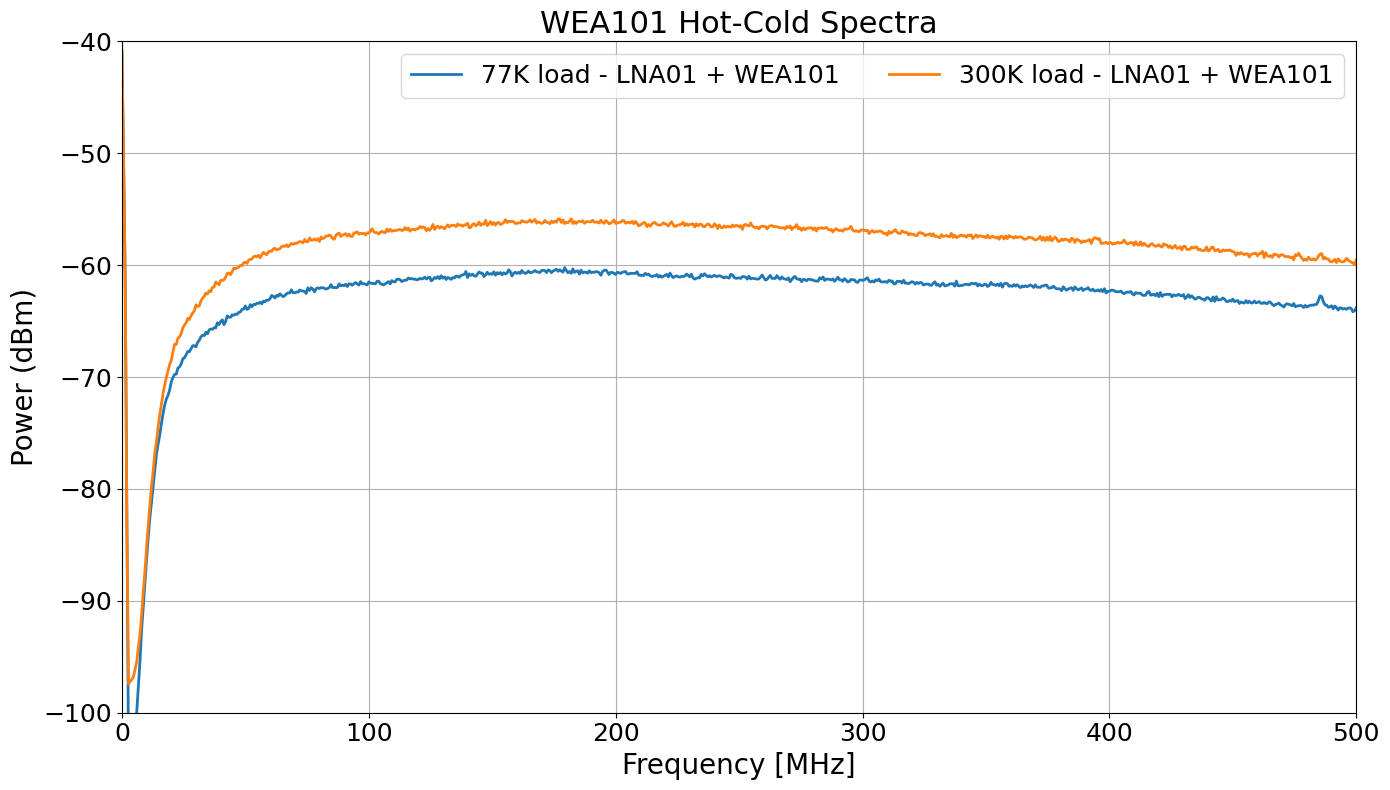

In [41]:
plotter.plot_spectrum([spectrum_D, spectrum_B], freq_range=freq_range, title='WEA101 Hot-Cold Spectra',
                        ylabel='Power (dBm)', ymax=-40, ymin=-100)

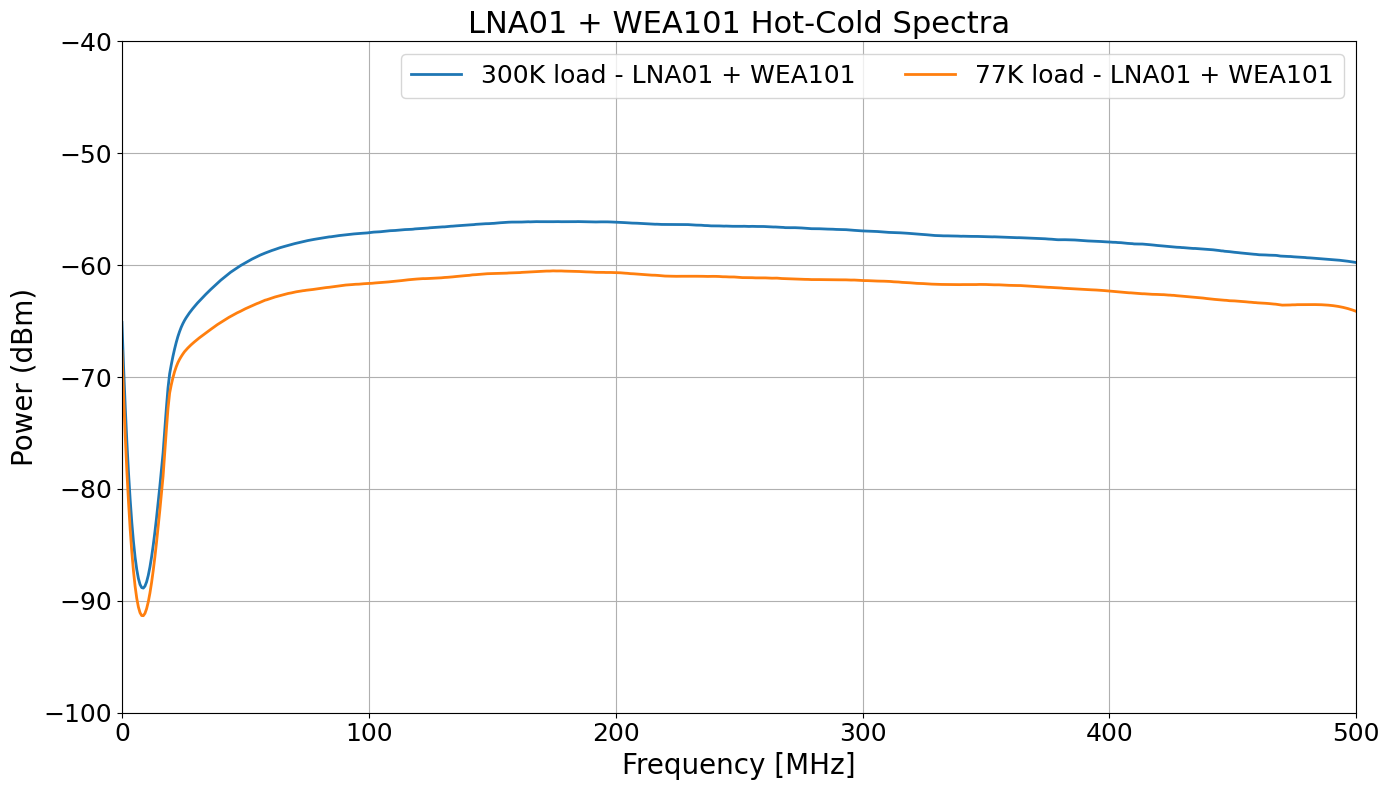

In [42]:
# smoothed spectra
spectrum_B.smooth(window_len=50, inplace=True)
spectrum_D.smooth(window_len=50, inplace=True)

plotter.plot_spectrum([spectrum_B, spectrum_D], freq_range=freq_range, title='LNA01 + WEA101 Hot-Cold Spectra', 
                      ylabel='Power (dBm)', ymax=-40, ymin=-100, save_dir=plot_path, suffix='smoothed')

In [43]:
# Calculate the Y-Factor thermometer
hot = spectrum_B.unit_convert('dBm', 'milliwatt', 1e6).spec
cold = spectrum_D.unit_convert('dBm', 'milliwatt', 1e6).spec
LNA01_thermo = Y_Factor_Thermometer(hot, cold, 'LNA01+WEA101', 300, 77, cal_hot=cal_hot, cal_cold=cal_cold, RBW=1e6)

frequency = spectrum_B.freq/1e6  # MHz

/Users/yuntongzhou/Desktop/DevSpace/Highz-EXP/src/highz_exp/fit_temperature.py:109: RuntimeWarning: invalid value encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / (cal_hot - cal_cold))


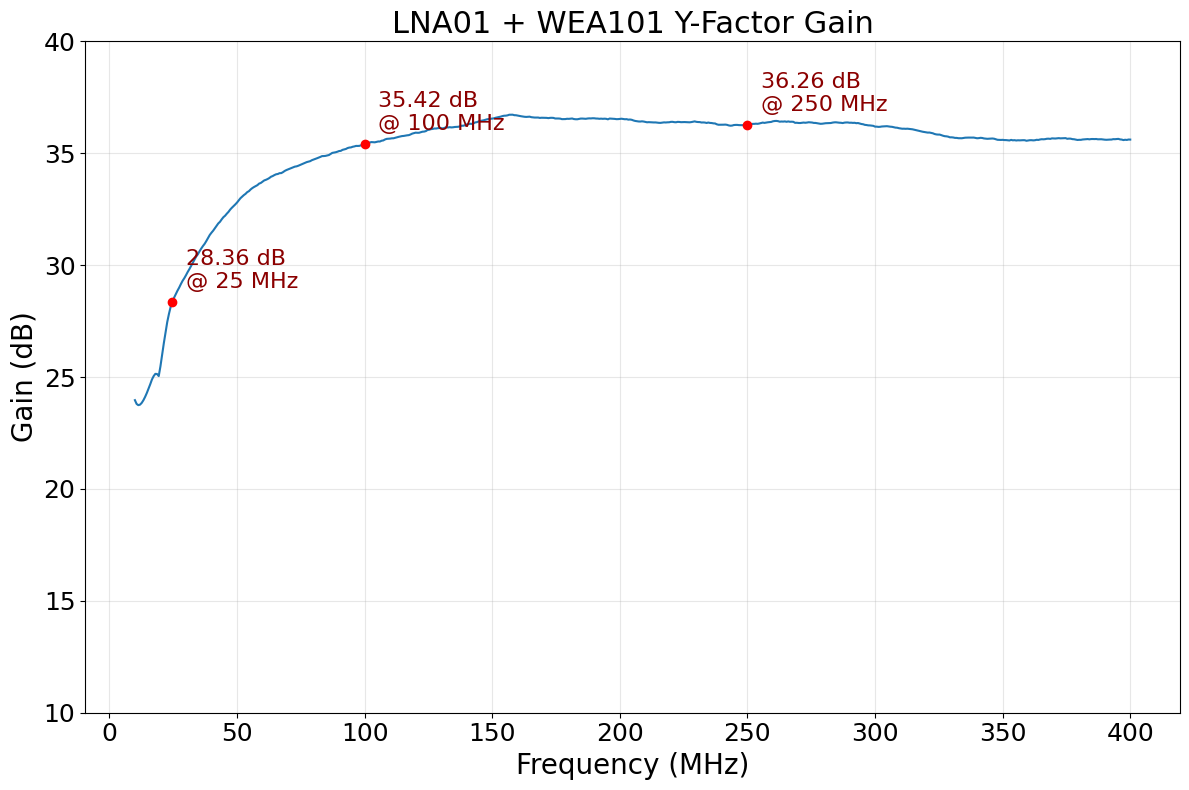

In [47]:
LNA01_thermo.plot_gain(f_mhz=frequency, title='LNA01 + WEA101 Y-Factor Gain',
                       ymax=40, ymin=10,
                       save_path=pjoin(plot_path, 'LNA01_WEA101_YFactor_Gain.png'), 
                       marker_freqs=[25, 100, 250])

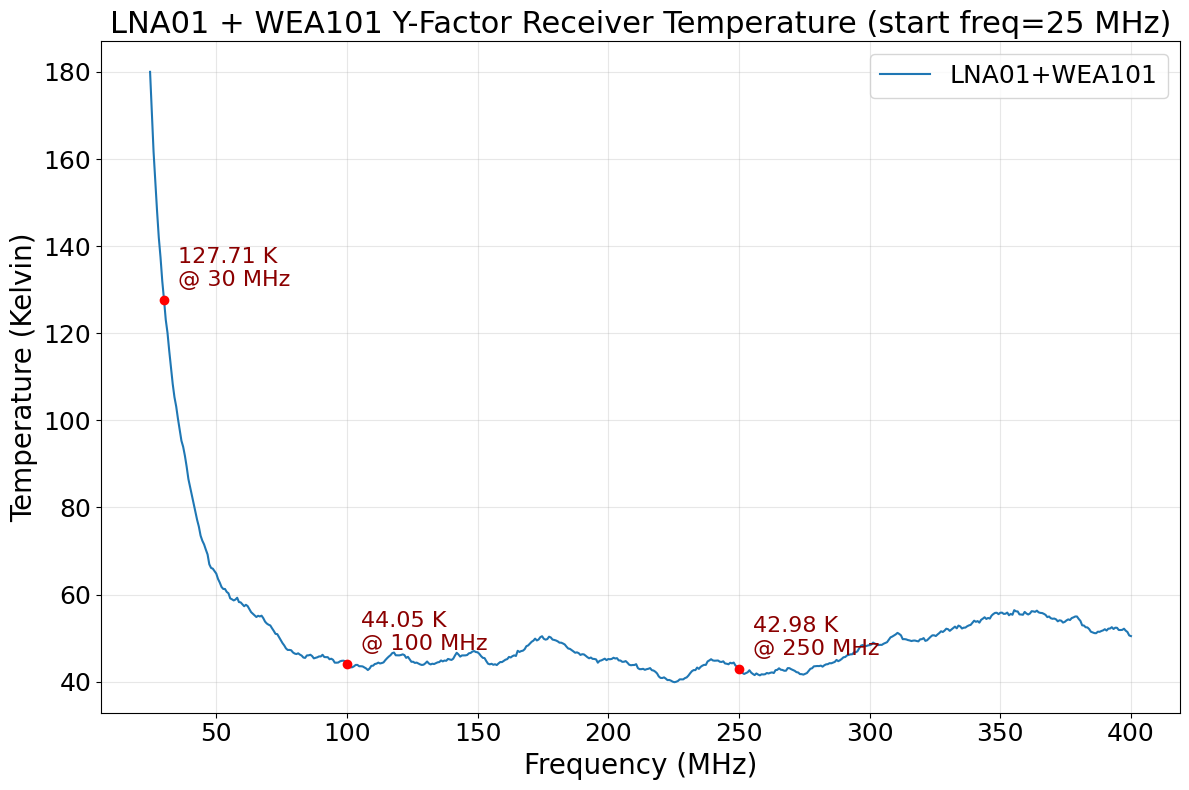

In [48]:
LNA01_thermo.plot_temps(faxis=frequency, temp_values=[LNA01_thermo.T_sys], labels=['LNA01+WEA101'],
                         title='LNA01 + WEA101 Y-Factor Receiver Temperature (start freq=25 MHz)',
                         start_freq=25,
                         save_path=pjoin(plot_path, 'LNA01_WEA101_YFactor_Temps.png'),
                         marker_freqs=[30, 100, 250])